### Imports
Import the required libraries

In [1]:
# package(s) related to time, space and id
import logging
import datetime, time
import platform
import itertools
# you need these dependencies (you can get these from anaconda)
# package(s) related to the simulation
import simpy
import pandas as pd

# spatial libraries 
import pyproj
import shapely.geometry
from simplekml import Kml, Style

# package(s) for data handling
import numpy as np
import matplotlib.pyplot as plt

# OpenTNSim
import opentnsim

# Used for mathematical functions
import math             
import tqdm
# Used for making the graph to visualize our problem
import networkx as nx   

import plotly.express as px
from plotly.subplots import make_subplots

# logging.basicConfig(level=logging.DEBUG) #turn on all the debug messages
logging.basicConfig(level=logging.INFO)# turn off all the debug messages


### Create graph


In [2]:
# specify a number of coordinate along your route (coords are: lon, lat)
coords = [
    [0,0],
    [0.646776,0],
    [4.087265,0], 
    [4.536415,0],
    [5.3898,0]
] 

# for each edge (between above coordinates) specify the depth (m)
depths = [6, 4.5, 3.2, 4.5]

# check of nr of coords and nr of depths align
assert len(coords) == len(depths) + 1, 'nr of depths does not correspond to nr of coords'

In [3]:
# create a graph based on coords and depths
FG = nx.DiGraph()
nodes = []
path = []

# add nodes
Node = type('Site', (opentnsim.core.Identifiable, opentnsim.core.Locatable), {})

for index, coord in enumerate(coords):
    data_node = {"name": "Node " + str(index), "geometry": shapely.geometry.Point(coord[0], coord[1])}
    nodes.append(Node(**data_node))
    
positions = {}
for node in nodes:
    positions[node.name] = (node.geometry.x, node.geometry.y)
    FG.add_node(node.name, geometry = node.geometry)

# add edges
path = [[nodes[i], nodes[i+1]] for i in range(len(nodes)-1)]

for index, edge in enumerate(path):
    # For the energy consumption calculation we add info to the graph. We need depth info for resistance.
    # NB: the CalculateEnergy routine expects the graph to have "Info" that contains "GeneralDepth" 
    #     this may not be very generic!
    FG.add_edge(edge[0].name, edge[1].name, weight = 1, Info = {"GeneralDepth": depths[index]})

# toggle to undirected and back to directed to make sure all edges are two way traffic
FG = FG.to_undirected() 
FG = FG.to_directed() 

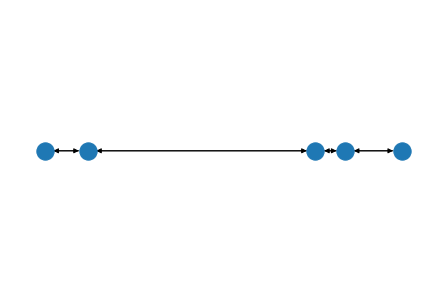

In [4]:
# show graph
nx.draw(FG, positions)
plt.show()

In [5]:
# This cell just shows that now a depth of 10 m is added to the edges. 
# You can use this to vary depths, e.g. make the middle edge shallower. Note that edges are bi-directional 
for edge in FG.edges:
    print('General depth for edge {} is {}'.format(edge, FG.get_edge_data(edge[0], edge[1])["Info"]["GeneralDepth"]))

General depth for edge ('Node 0', 'Node 1') is 6
General depth for edge ('Node 1', 'Node 0') is 6
General depth for edge ('Node 1', 'Node 2') is 4.5
General depth for edge ('Node 2', 'Node 1') is 4.5
General depth for edge ('Node 2', 'Node 3') is 3.2
General depth for edge ('Node 3', 'Node 2') is 3.2
General depth for edge ('Node 3', 'Node 4') is 4.5
General depth for edge ('Node 4', 'Node 3') is 4.5


### Create vessel - add VesselProperties and ConsumesEnergy mixins


In [6]:
# Make your preferred class out of available mix-ins.
TransportResource = type(
    "Vessel",
    (
        opentnsim.core.Identifiable,
        opentnsim.core.Movable,
        opentnsim.core.VesselProperties,  # needed to add vessel properties
        opentnsim.energy.ConsumesEnergy,
        opentnsim.core.ExtraMetadata,
    ),
    {},
)  # needed to calculate resistances

In [7]:
# Create a dict with all important settings

data_vessel = {
    "env": None,
    "name": 'Vessel',
    "route": None,
    "geometry": None,
    "v": 1,  # m/s
    "type": None,
    "B": 11.4,
    "L": 135,
    "H_e": None, 
    "H_f": None, 
    "T": 2.6,
    "safety_margin": 0.3, # for tanker vessel with rocky bed the safety margin is recommended as 0.3 m
    "h_squat": True, # if consider the ship squatting while moving, set to True, otherwise set to False. Note that here we have disabled h_squat calculation since we regard the water depth h_0 is already reduced by squat effect. This applies to figures 3, 5, 7, 8 and 9.
    "payload":None,
    "vessel_type":"Tanker", #vessel types: "Container","Dry_SH","Dry_DH","Barge","Tanker". ("Dry_SH" means dry bulk single hull, "Dry_DH" means dry bulk double hull)    
    "P_installed": 2000, # kW  
    "P_tot_given": None, # kW
    "bulbous_bow": False, # if a vessel has no bulbous_bow, set to False; otherwise set to True.
    "P_hotel_perc": 0,
    "P_hotel": None, # None: calculate P_hotel from percentage
    "x": 2,# number of propellers
    "L_w": 3.0 ,
    "C_B":0.9, 
    "C_year": 2000,
}             



### Define paths
We are going to create a simulation in which a vessel moves from *Node 1* to *Node 4*. Therefore, we need to create a vessel to which we will need to append this paths. Therefore, first let's create the path.

In [8]:
path = nx.dijkstra_path(FG, nodes[0].name, nodes[4].name)

### Run simulation


In [9]:
def run_simulation(V_s):
    
    # Start simpy environment
    simulation_start = datetime.datetime.now()
    env = simpy.Environment(initial_time = time.mktime(simulation_start.timetuple()))
    env.epoch = time.mktime(simulation_start.timetuple())

    # Add graph to environment
    env.FG = FG

    # Add environment and path to the vessel
    # create a fresh instance of vessel
    vessel = TransportResource(**data_vessel)
    vessel.env = env                                        #the created environment
    vessel.name = 'Vessel No.1'                     
    vessel.route = path                                     #the route (the sequence of nodes, as stored as the second column in the path)
    vessel.geometry = env.FG.nodes[path[0]]['geometry']     #a shapely.geometry.Point(lon,lat) (here taken as the starting node of the vessel)
    vessel.v = V_s
    # vessel.P_tot_given = P_tot_given
    
    # Start the simulation
    env.process(vessel.move())
    env.run()
    
    return vessel

In [10]:
input_data = {'V_s': [3.61]} # 605km/50hr=12.1 km/h    10km/h, 12km/h, 13km/h
input_data

{'V_s': [3.61]}

In [11]:
# create empty plot data
plot_data = {}

# loop through the various input data
for index, value in enumerate(input_data['V_s']):
    
    # Run a basic simulation with V_s and P_tot_given combi
    vessel = run_simulation(input_data['V_s'][index])
    
    # create an EnergyCalculation object and perform energy consumption calculation
    energycalculation = opentnsim.energy.EnergyCalculation(FG, vessel)
    energycalculation.calculate_energy_consumption()
    
    # create dataframe from energy calculation computation
    df = pd.DataFrame.from_dict(energycalculation.energy_use)
    
    # add/modify some comlums to suit our plotting needs
   
    df['fuel_kg_per_km'] = (df['total_diesel_consumption_C_year_ICE_mass']/1000) / (df['distance']/1000)  # g/m --> kg/km
    df['CO2_g_per_km']   = (df['total_emission_CO2']) / (df['distance']/1000)
    df['PM10_g_per_km']  = (df['total_emission_PM10']) / (df['distance']/1000)
    df['NOx_g_per_km']   = (df['total_emission_NOX']) / (df['distance']/1000)
    
    label = 'V_s = ' + str(input_data['V_s'][index]) 

    # Note that we make a dict to collect all plot data. 
    # We use labels like ['V_s = None P_tot_given = 274 fuel_kg_km'] to organise the data in the dict
    # The [0, 0, 1, 1, 2, 2] below creates a list per section (I think this is the way you use it in your plot)
    # plot_data[label + ' v'] = list(df.distance[[0, 0, 1, 1, 2, 2]]/df.delta_t[[0, 0, 1, 1, 2, 2]])
    # plot_data[label + ' P_tot']   = list(df.P_tot[[0, 0, 1, 1, 2, 2]])
    plot_data[label + ' fuel_kg_per_km']   = list(df.fuel_kg_per_km[[0, 0, 1, 1, 2, 2, 3, 3]])
    plot_data[label + ' CO2_g_per_km'] = list(df.CO2_g_per_km[[0, 0, 1, 1, 2, 2, 3, 3]])
    plot_data[label + ' PM10_g_per_km']   = list(df.PM10_g_per_km[[0, 0, 1, 1, 2, 2, 3, 3]])
    plot_data[label + ' NOx_g_per_km']   = list(df.NOx_g_per_km[[0, 0, 1, 1, 2, 2, 3, 3]])
        

5.837542412070288
4.294911939775802
2.9296844488968694
4.294911939765771


C:\ANACONDA2021\envs\sim\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning:

The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.



In [12]:
# this is now in the plot data
plot_data

{'V_s = 3.61 fuel_kg_per_km': [7.5591353411904825,
  7.5591353411904825,
  13.883267418585762,
  13.883267418585762,
  16.681658854787024,
  16.681658854787024,
  13.883267419424481,
  13.883267419424481],
 'V_s = 3.61 CO2_g_per_km': [23967.99010621372,
  23967.99010621372,
  44020.11620527193,
  44020.11620527193,
  52893.06466151983,
  52893.06466151983,
  44020.11620793128,
  44020.11620793128],
 'V_s = 3.61 PM10_g_per_km': [11.361205945909296,
  11.361205945909296,
  19.553657748569503,
  19.553657748569503,
  23.706718126223183,
  23.706718126223183,
  19.553657749739,
  19.553657749739],
 'V_s = 3.61 NOx_g_per_km': [330.40703329571807,
  330.40703329571807,
  608.2968972697854,
  608.2968972697854,
  736.8195887627772,
  736.8195887627772,
  608.2968973110084,
  608.2968973110084]}

### diesel fuel and emissions in kg/km, g/km

In [13]:
df['fuel_kg_per_km'] = (df['total_diesel_consumption_C_year_ICE_mass']/1000) / (df['distance']/1000)  # g/m --> kg/km
df['CO2_g_per_km']   = (df['total_emission_CO2']) / (df['distance']/1000)
df['PM10_g_per_km']  = (df['total_emission_PM10']) / (df['distance']/1000)
df['NOx_g_per_km']   = (df['total_emission_NOX']) / (df['distance']/1000)

In [14]:
df_km=df[['fuel_kg_per_km','CO2_g_per_km','PM10_g_per_km','NOx_g_per_km']]
df_km

,fuel_kg_per_km,CO2_g_per_km,PM10_g_per_km,NOx_g_per_km
0,7.559135,23967.990106,11.361206,330.407033
1,13.883267,44020.116205,19.553658,608.296897
2,16.681659,52893.064662,23.706718,736.819589
3,13.883267,44020.116208,19.553658,608.296897


### diesel fuel and emissions in g/tkm (in sections)

In [15]:
payload_ton = 2200

In [16]:
df['fuel_g_per_tkm']=(df['total_diesel_consumption_C_year_ICE_mass']) / (df['distance']/1000)/payload_ton
df['CO2_g_per_tkm']=df['CO2_g_per_km']/payload_ton
df['PM10_g_per_tkm']=df['PM10_g_per_km']/payload_ton
df['NOx_g_per_tkm']=df['NOx_g_per_km']/payload_ton

In [17]:
df_tkm=df[['fuel_g_per_tkm','CO2_g_per_tkm','PM10_g_per_tkm','NOx_g_per_tkm']]
df_tkm

,fuel_g_per_tkm,CO2_g_per_tkm,PM10_g_per_tkm,NOx_g_per_tkm
0,3.435971,10.894541,0.005164,0.150185
1,6.310576,20.009144,0.008888,0.276499
2,7.582572,24.042302,0.010776,0.334918
3,6.310576,20.009144,0.008888,0.276499


### diesel fuel and emissions in g/tkm  mean value

In [18]:
df_tkm_mean = df_tkm.mean()
df_tkm_mean = pd.DataFrame(df_tkm_mean)
df_tkm_mean.T

,fuel_g_per_tkm,CO2_g_per_tkm,PM10_g_per_tkm,NOx_g_per_tkm
0,5.909924,18.738783,0.008429,0.259525


### diesel fuel and emissions in g/s (roundtrip-average)    

note that g/s may not be constant even in a same water depth section.  Because the sailing duration is determined by the ship speed relative to the ground, which is influenced by current directions and speeds.

In [19]:
df['fuel_g_per_sec'] = (df['total_diesel_consumption_C_year_ICE_mass']) / (df['distance']/vessel.v)  # g/s
df['CO2_g_per_sec'] = (df['total_emission_CO2']) / (df['distance']/vessel.v)  # g/s
df['PM10_g_per_sec'] = (df['total_emission_PM10']) / (df['distance']/vessel.v)  # g/s
df['NOx_g_per_sec'] = (df['total_emission_NOX']) / (df['distance']/vessel.v)  # g/s

In [20]:
df_s=df[['fuel_g_per_sec','CO2_g_per_sec','PM10_g_per_sec','NOx_g_per_sec']]
df_s

,fuel_g_per_sec,CO2_g_per_sec,PM10_g_per_sec,NOx_g_per_sec
0,27.288479,86.524444,0.041014,1.192769
1,50.118595,158.912620,0.070589,2.195952
2,60.220788,190.943963,0.085581,2.659919
3,50.118595,158.912620,0.070589,2.195952


### diesel fuel and emissions in ton, kg per round-trip (laden going and returning)

In [21]:
df['fuel_ton']=(df['total_diesel_consumption_C_year_ICE_mass'].sum()/1000000)*2  #ton
df['fuel_liters'] = df['fuel_ton'] * 1162.79 # liters
df['CO2_ton']=(df['total_emission_CO2'].sum()/1000000)*2  #ton
df['PM10_kg']=(df['total_emission_PM10'].sum()/1000)*2  #kg
df['NOx_kg']=(df['total_emission_NOX'].sum()/1000)*2  #kg

In [22]:
df_roundtrip=df[['fuel_ton','fuel_liters','CO2_ton','PM10_kg','NOx_kg']]
df_roundtrip.head(1)

,fuel_ton,fuel_liters,CO2_ton,PM10_kg,NOx_kg
0,16.028812,18638.14266,50.823063,22.699596,702.780448


In [23]:
### ton, kg per single-trip (laden going), upstream

In [24]:
# duration_upstream = 65 * 3600 # second
# duration_downstream = 35 * 3600 # second

In [25]:
# df['fuel_ton_single_up'] = df['fuel_ton'] * duration_upstream /(duration_upstream + duration_downstream)
# df['fuel_liters_single_up'] = df['fuel_ton_single_up'] * 1162.79 # liters
# df['fuel_ton_single_down'] = df['fuel_ton'] * duration_downstream /(duration_upstream + duration_downstream)
# df['fuel_liters_single_down'] = df['fuel_ton_single_down'] * 1162.79 # liters

In [26]:
# df_single_trips=df[['fuel_ton_single_up','fuel_liters_single_up','fuel_ton_single_down','fuel_liters_single_down']]
# df_single_trips.head(1)

### diesel fuel and emissions in ton per year

In [27]:
num_roundtrip = 26

In [28]:
df['fuel_ton_per_yr']=df['fuel_ton']*num_roundtrip
df['CO2_ton_per_yr'] = df['CO2_ton']*num_roundtrip
df['PM10_ton_per_yr'] = df['PM10_kg']*num_roundtrip/1000
df['NOx_ton_per_yr'] = df['NOx_kg']*num_roundtrip/1000

In [29]:
df_year = df[['fuel_ton_per_yr','CO2_ton_per_yr','PM10_ton_per_yr','NOx_ton_per_yr']]
df_year.head(1)

,fuel_ton_per_yr,CO2_ton_per_yr,PM10_ton_per_yr,NOx_ton_per_yr
0,416.74912,1321.399649,0.590189,18.272292


## alternatives in mass and volume per round-trip (laden going and returning)

In [30]:
df['LH2_PEMFC_ton']=(df['total_LH2_consumption_PEMFC_mass'].sum()/1000000)*2  #ton
df['LH2_SOFC_ton']=(df['total_LH2_consumption_SOFC_mass'].sum()/1000000)*2  #ton
df['eLNG_PEMFC_ton']=(df['total_eLNG_consumption_PEMFC_mass'].sum()/1000000)*2  #ton
df['eLNG_SOFC_ton']=(df['total_eLNG_consumption_SOFC_mass'].sum()/1000000)*2  #ton
df['eLNG_ICE_ton']=(df['total_eLNG_consumption_ICE_mass'].sum()/1000000)*2  #ton
df['eMethanol_PEMFC_ton']=(df['total_eMethanol_consumption_PEMFC_mass'].sum()/1000000)*2  #ton
df['eMethanol_SOFC_ton']=(df['total_eMethanol_consumption_SOFC_mass'].sum()/1000000)*2  #ton
df['eMethanol_ICE_ton']=(df['total_eMethanol_consumption_ICE_mass'].sum()/1000000)*2  #ton
df['eNH3_PEMFC_ton']=(df['total_eNH3_consumption_PEMFC_mass'].sum()/1000000)*2  #ton
df['eNH3_SOFC_ton']=(df['total_eNH3_consumption_SOFC_mass'].sum()/1000000)*2  #ton
df['eNH3_ICE_ton']=(df['total_eNH3_consumption_ICE_mass'].sum()/1000000)*2  #ton
df['Li_NMC_Battery_ton']=(df['total_Li_NMC_Battery_mass'].sum()/1000000)*2  #ton

df_alternatives_mass_roundtrip=df[['LH2_PEMFC_ton','LH2_SOFC_ton','eLNG_PEMFC_ton','eLNG_SOFC_ton','eLNG_ICE_ton',
                             'eMethanol_PEMFC_ton','eMethanol_SOFC_ton','eMethanol_ICE_ton','eNH3_PEMFC_ton',
                            'eNH3_SOFC_ton','eNH3_ICE_ton','Li_NMC_Battery_ton']]
df_alternatives_mass_roundtrip.head(1)

,LH2_PEMFC_ton,LH2_SOFC_ton,eLNG_PEMFC_ton,eLNG_SOFC_ton,eLNG_ICE_ton,eMethanol_PEMFC_ton,eMethanol_SOFC_ton,eMethanol_ICE_ton,eNH3_PEMFC_ton,eNH3_SOFC_ton,eNH3_ICE_ton,Li_NMC_Battery_ton
0,5.215799,5.093976,13.059105,12.754091,15.470781,31.752485,31.010861,37.616342,33.989451,33.195579,40.266417,832.728341


In [31]:
df['LH2_PEMFC_m3']=(df['total_LH2_consumption_PEMFC_vol'].sum())*2  
df['LH2_SOFC_m3']=(df['total_LH2_consumption_SOFC_vol'].sum())*2  
df['eLNG_PEMFC_m3']=(df['total_eLNG_consumption_PEMFC_vol'].sum())*2  
df['eLNG_SOFC_m3']=(df['total_eLNG_consumption_SOFC_vol'].sum())*2  
df['eLNG_ICE_m3']=(df['total_eLNG_consumption_ICE_vol'].sum())*2  
df['eMethanol_PEMFC_m3']=(df['total_eMethanol_consumption_PEMFC_vol'].sum())*2  
df['eMethanol_SOFC_m3']=(df['total_eMethanol_consumption_SOFC_vol'].sum())*2  
df['eMethanol_ICE_m3']=(df['total_eMethanol_consumption_ICE_vol'].sum())*2  
df['eNH3_PEMFC_m3']=(df['total_eNH3_consumption_PEMFC_vol'].sum())*2  
df['eNH3_SOFC_m3']=(df['total_eNH3_consumption_SOFC_vol'].sum())*2  
df['eNH3_ICE_m3']=(df['total_eNH3_consumption_ICE_vol'].sum())*2  
df['Li_NMC_Battery_m3']=(df['total_Li_NMC_Battery_vol'].sum())*2  


df_alternatives_vol_roundtrip=df[['LH2_PEMFC_m3','LH2_SOFC_m3','eLNG_PEMFC_m3','eLNG_SOFC_m3','eLNG_ICE_m3',
                             'eMethanol_PEMFC_m3','eMethanol_SOFC_m3','eMethanol_ICE_m3','eNH3_PEMFC_m3',
                            'eNH3_SOFC_m3','eNH3_ICE_m3','Li_NMC_Battery_m3']]
df_alternatives_vol_roundtrip.head(1)

,LH2_PEMFC_m3,LH2_SOFC_m3,eLNG_PEMFC_m3,eLNG_SOFC_m3,eLNG_ICE_m3,eMethanol_PEMFC_m3,eMethanol_SOFC_m3,eMethanol_ICE_m3,eNH3_PEMFC_m3,eNH3_SOFC_m3,eNH3_ICE_m3,Li_NMC_Battery_m3
0,67.952305,66.365184,30.800868,30.08147,36.488986,40.084489,39.14826,47.487051,55.331664,54.039315,65.549981,658.993651
